In [20]:
import torch
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F

from utils import layers, hooking, img, stats, models, losses
from stepping import loss, closure

In [3]:
vgg = models.vgg19()

In [4]:
hooker = hooking.Hooker(vgg)
hooker.attach_hooks("texture_hooks", [3, 6, 19, 26, 37])
hook_bag = hooker.get_bag()
vgg = layers.clipped_model(vgg, hooker.last_hooked_index())

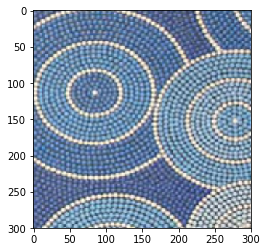

In [5]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(300),
    transforms.ToTensor(),
])

example_texture = img.image_loader("data/original/rings-2.jpg", transform)
img.show_image(example_texture)

In [32]:
vgg(example_texture)
target = stats.extract_features(hook_bag.get_hook("texture_hooks"), stats.gram_matrix)

def texture_loss_fn(target_grams, sample_features):
    sample_grams = [stats.gram_matrix(feature) for feature in sample_features]
    loss = 0
    
    for i in range(len(sample_grams)):
        loss += F.mse_loss(sample_grams[i], target_grams[i])
    
    return loss * 1000000

texture_loss = loss.LossFn(target, hook_bag.get_hook("texture_hooks"), texture_loss_fn)

def smooth_loss(target_grams, sample_features):
    loss = 0
    for layer in sample_features:
        loss += losses.smoothing_loss(layer)
    return loss * 10000

smoothness_loss = loss.LossFn(None, hook_bag.get_hook("texture_hooks"), smooth_loss) 

In [33]:
collector = loss.LossCollector()
collector.add_loss_fn("texture", texture_loss)
collector.add_loss_fn("texture", smoothness_loss)

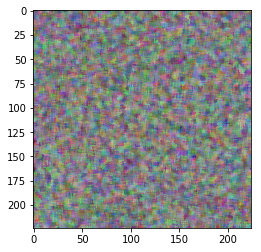

In [34]:
sample_texture = img.random_image(5, 224)
img.show_image(sample_texture)

inputs = {
    "input": sample_texture,
    "loss_name": "texture",
    "pyramid": False,
}

optimizer = optim.LBFGS([sample_texture])

In [35]:
stepper = closure.Stepper(inputs, vgg, collector, optimizer)

In [39]:
importlib.reload(stats)
for i in range(128):
    optimizer.step(stepper.loss_fn)

img.save_image(sample_texture, "data/synth/rings-2.jpg")

torch.Size([1, 64, 224, 224])
torch.Size([8, 1, 64, 224, 224])
torch.Size([8, 1, 64, 224, 224])
torch.Size([8, 1, 64, 224, 224])
torch.Size([8, 1, 64, 224, 224])


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [214]:
img.save_image(sample_texture, "data/synth/rings-2.jpg")